In [2]:
from mayavi import mlab
from tvtk.tvtk_access import tvtk
import hermes
from hermes.analysis import CoverageAnalysis, LOSAnalysis
from hermes.constellations.Telesat import Telesat_00053
from hermes.objects import Satellite
from hermes.scenario import Scenario

from hermes.postprocessing import generate_pass_df, generate_gap_df

from astropy.coordinates import GCRS, CartesianRepresentation, ITRS, SphericalRepresentation

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
from poliastro.bodies import Earth
from astropy import units as u, time
from notebooks.PlotUtil import apply_report_formatting

import cartopy.crs as ccrs

%matplotlib inline

mlab.init_notebook('ipy', local=True)

# PDF exporter defaults
ex = tvtk.GL2PSExporter()
ex.file_format = 'pdf'
ex.sort = 'bsp'
ex.compress = 1
#ex.edit_traits(kind='livemodal')

figures_dir = 'D:/git/thesis_report_ae/figures/visibility_analysis'

C:\git\hermes-simulator\cenv\lib\site-packages\astropy\units\decorators.py:222: UserWarning: Wrapping true anomaly to -π <= nu < π
  return_ = wrapped_function(*func_args, **func_kwargs)


Notebook initialized with ipy backend.


# Telesat

In [3]:
columns = ['strand_name', 'tof', 'r_a_x', 'r_a_y', 'r_a_z', 'r_b_x', 'r_b_y', 'r_b_z']

#store_500km = pd.HDFStore("Test_LOSAnalysis_sat_500km_90deg_to_Telesat_2020-12-31_08-50-39.h5")
#store_500km = pd.HDFStore("2021-01-02_10-51-23_Test_LOSAnalysis_sat_500km_97deg_to_Telesat.h5")
store_500km = pd.HDFStore("2021-01-02_11-39-41_Test_LOSAnalysis_sat_500km_97deg_to_Telesat.h5")
instances_500km_df = store_500km.select('contact_instances', 'columns = %s' % str(columns))

In [4]:
#store_400km = pd.HDFStore("Test_LOSAnalysis_sat_400km_51deg_to_Telesat_2020-12-31_08-50-33.h5")
#store_400km = pd.HDFStore("2021-01-02_10-51-17_Test_LOSAnalysis_sat_400km_51deg_to_Telesat.h5")
store_400km = pd.HDFStore("2021-01-02_11-39-35_Test_LOSAnalysis_sat_400km_51deg_to_Telesat.h5")
instances_400km_df = store_400km.select('contact_instances', 'columns = %s' % str(columns))

In [5]:
pass_500km_df = generate_pass_df(instances_500km_df)
gaps_500km_df = generate_gap_df(instances_500km_df)

pass_400km_df = generate_pass_df(instances_400km_df)
gaps_400km_df = generate_gap_df(instances_400km_df)

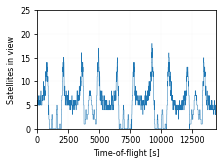

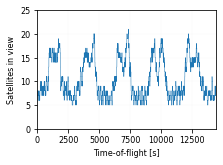

In [6]:
def contact_timeline(pass_df):
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    tof_max = (4 * u.hour).to(u.s).value

    tofs = np.arange(tof_max)

    def satellites_in_view(pass_df, tofs):
        num_in_view = np.zeros((len(tofs), ))
        for i, tof in enumerate(tofs):
            in_view = (pass_df['start_tof'] <= tof) & (tof <= pass_df['end_tof'])
            num_in_view[i] = in_view.sum()
        return num_in_view

    ax.step(tofs, satellites_in_view(pass_df, tofs), linewidth=0.5)
    ax.set_xlim((0, tof_max))
    ax.set_ylim((0, 25))
    ax.set_xlabel('Time-of-flight [s]')
    ax.set_ylabel('Satellites in view')
    ax.grid(linestyle=':', linewidth = 0.1)
    apply_report_formatting()

    #plt.show()

contact_timeline(pass_500km_df)
#plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.pgf')
#plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.svg')
plt.savefig(figures_dir + '/Telesat_in_view_500km97deg.pdf')
plt.show()

contact_timeline(pass_400km_df)
#plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.pgf')
#plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.svg')
plt.savefig(figures_dir + '/Telesat_in_view_400km51deg.pdf')
plt.show()

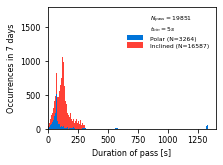

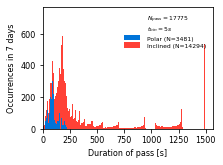

In [7]:
def plot_pass_temporal_distribution(pass_df, bin_size = 5.0):

    durations_np = pass_df.duration.to_numpy()

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{pass} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    # Split into polar and inclined orbits
    polar_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 1015*1000, atol=100)
    inc_sat = np.isclose(pass_df.r_b_norm - Earth.R_mean.to(u.m).value, 1325*1000, atol=100)

    durations_np = [durations_np[polar_sat], durations_np[inc_sat]]

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               histtype='bar',
                               stacked=True,
                               color=["#0074D9", "#FF4136"],
                               label=['Polar (N=%d)' % polar_sat.sum(),
                                      'Inclined (N=%d)' % inc_sat.sum()])

    ax.set_xlabel('Duration of pass [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.set_xlim((0, ax.get_xlim()[1]))

    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

plot_pass_temporal_distribution(pass_500km_df)
apply_report_formatting()
plt.savefig(figures_dir + '/Telesat_pass_distribution_500km97deg.pdf')
plt.show()

plot_pass_temporal_distribution(pass_400km_df)
apply_report_formatting()
plt.savefig(figures_dir + '/Telesat_pass_distribution_400km51deg.pdf')
plt.show()

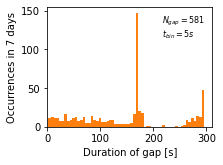

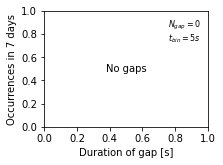

In [8]:
def plot_gap_temporal_distribution(gaps_df, bin_size = 5.0):

    durations_np = gaps_df.duration.to_numpy()
    count = len(durations_np)

    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))

    ax.plot(np.NaN, np.NaN, '-', color='none', label='$N_{gap} = %d$' % (count))
    ax.plot(np.NaN, np.NaN, '-', color='none', label='$t_{bin} = %ds$' % (bin_size))

    ax.set_xlabel('Duration of gap [s]')
    ax.set_ylabel('Occurrences in 7 days')
    ax.legend(loc='upper right', frameon=False, labelspacing=0.1, fontsize=8)

    if len(durations_np) == 0:
        ax.text(0.5, 0.50,
            'No gaps',
             horizontalalignment='center',
             verticalalignment='center',
             transform = ax.transAxes)
        ax.set_xlim((0,1))
        ax.set_ylim((0,1))

        return

    bins = int(np.max(durations_np))
    bins = int(bins / bin_size) # x second bins

    n, bins, patches = ax.hist(durations_np,
                               bins=bins,
                               stacked=True,
                               color = "tab:orange",
                               lw=0,
                               label='Gaps')


    ax.set_xlim((0, ax.get_xlim()[1]))

    average = np.average(durations_np)
    std_dev = np.std(durations_np)

plot_gap_temporal_distribution(gaps_500km_df)
plt.savefig(figures_dir + '/Telesat_gap_distribution_500km97deg.pdf')
plt.show()

plot_gap_temporal_distribution(gaps_400km_df)
plt.savefig(figures_dir + '/Telesat_gap_distribution_400km51deg.pdf')
plt.show()

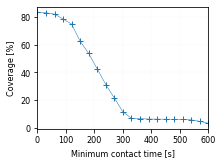

15s, 83.5%
30s, 83.3%
60s, 82.3%
150s, 62.6%
300s, 11.4%
600s, 3.1%


15s, 100.0%
30s, 100.0%
60s, 100.0%
150s, 99.9%
300s, 80.3%
600s, 69.2%




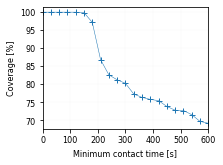

In [10]:
def plot_temporal_coverage(instances_df, pass_df, tof_end = None, min_durations=np.arange(0, 315, 15)):

    if tof_end is None:
        tof_end = max(instances_df['tof'])

    percentages = np.zeros((len(min_durations),))

    for i, min_duration in enumerate(min_durations):

        # First we find which passes are long enough to include:
        long_passes = pass_df[pass_df.duration >= min_duration]

        # And use that to filter the instances
        long_instances_df = instances_df[instances_df.index.isin(long_passes.index, level='p')]

        if long_instances_df.size > 0:
            # Then we compute the gaps
            long_gap_df = generate_gap_df(long_instances_df, tof_end=tof_end)

            # Then we compute the total gap duration
            total_gap_duration = long_gap_df[long_gap_df['end_tof'] <= tof_end].duration.sum()

            # And compute the coverage percentage
            percentages[i] = 1 - min(1, total_gap_duration / tof_end)
        else:
            percentages[i] = 0

    ## DO PLOTTING
    fig, ax = plt.subplots(tight_layout=True, figsize=(3.2, 2.4))
    ax.plot(min_durations, percentages * 100, '-+', linewidth=0.5)
    ax.set_xlabel('Minimum contact time [s]')
    ax.set_ylabel('Coverage [%]')
    ax.grid(linestyle=':', linewidth=0.1)
    ax.set_xlim((0, max(min_durations)))
    apply_report_formatting()

    return min_durations, percentages

min_durations, percentages = plot_temporal_coverage(instances_500km_df, pass_500km_df, min_durations=np.arange(0, 630, 30))
#plt.savefig(figures_dir + '/Telesat_coverage_vs_time_500km97deg.svg')
plt.savefig(figures_dir + '/Telesat_coverage_vs_time_500km97deg.pdf')
plt.show()

interp_durations = [15, 30, 60, 150, 300, 600]
interp_percentages = np.interp(interp_durations, min_durations, percentages)

for d, p in zip(interp_durations, interp_percentages):
    print("%ds, %0.1f%%" % (d, p * 100))
print("\n")

min_durations, percentages = plot_temporal_coverage(instances_400km_df, pass_400km_df, min_durations=np.arange(0, 630, 30))
#plt.savefig(figures_dir + '/Telesat_coverage_vs_time_400km51deg.svg')
plt.savefig(figures_dir + '/Telesat_coverage_vs_time_400km51deg.pdf')
plt.show()

interp_percentages = np.interp(interp_durations, min_durations, percentages)

for d, p in zip(interp_durations, interp_percentages):
    print("%ds, %0.1f%%" % (d, p * 100))
print("\n")

### Spatial coverage
This runs a spatial coverage simulation and analysis at several altitudes using the
``hermes.analysis.CoverageAnalysis`` class.

In [ ]:
def run_spatial_coverage_simulation():

    start = time.Time('2019-09-01 10:00:00.000', scale='tt')        # Start time of simulation
    stop = time.Time('2019-09-07 10:00:00.000', scale='tt')         # Stop time of simulation
    step = 1 * u.s

    scenario = Scenario(start, stop, step, hermes.objects.Earth, name='Test')

    # Constellation
    constellation = Telesat_00053
    scenario.add_satellite(constellation)

    # Add line-of-sight analysis
    # analysis = CoverageAnalysis(scenario, constellation, altitude=1300 * u.km)
    # scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=1000 * u.km)
    scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=750 * u.km)
    scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=500 * u.km)
    scenario.add_analysis(analysis)

    analysis = CoverageAnalysis(scenario, constellation, altitude=400 * u.km)
    scenario.add_analysis(analysis)

    # analysis = CoverageAnalysis(scenario, constellation, altitude=200 * u.km)
    # scenario.add_analysis(analysis)

    # Initialise the scenario
    scenario.initialise()

    output_tuples = [None] * len(scenario.state.analyses)

    for i, analysis in enumerate(scenario.state.analyses):
        writer = analysis.generate_writer(directory = 'raw_data')
        writer.initialise()
        writer.flush()
        output_tuples[i] = (writer.file_path, '%dkm' % analysis.altitude.to(u.km).value)
        del writer

    return output_tuples

from os import path
import pickle

if path.isfile('coverage_list.p'):
    coverage_list = pickle.load(open('coverage_list.p', 'rb'))
else:
    coverage_list = run_spatial_coverage_simulation()
    pickle.dump(coverage_list, open('coverage_list.p', 'wb'))

In [ ]:
def plot_coverage_spatial(coverage_df):

    # Calculate lat longs
    epoch = time.Time('J2017', scale='tt')
    obs_times = epoch + coverage_df['tof'].values * u.s
    gcrs_xyz = GCRS(x=coverage_df['r_x'], y=coverage_df['r_y'], z=coverage_df['r_z'],
                    obstime=obs_times, representation_type=CartesianRepresentation)
    itrs_xyz = gcrs_xyz.transform_to(ITRS(obstime=obs_times))
    itrs_latlon = itrs_xyz.represent_as(SphericalRepresentation)

    coverage_df['r_lat'] = itrs_latlon.lat.to(u.deg)
    coverage_df['r_lon'] = ((itrs_latlon.lon + np.pi * u.rad) % (2*np.pi * u.rad) - np.pi * u.rad).to(u.deg)

    ## Plotting
    fig = plt.figure(figsize=(12,8))
    ax = plt.axes([0.1,0.1,.9,.9], projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels=True)

    step = 1
    llon = np.arange(-180, 180 + step, step)
    llat = np.arange(-90, 90 + step, step)

    # Set zero to NaN so it isn't accounted in the contour plot
    coverage_df.loc[coverage_df['num_los'] == 0, 'num_los'] = np.nan

    from scipy.interpolate import griddata
    val = griddata((coverage_df['r_lon'], coverage_df['r_lat']), coverage_df['num_los'],
                   (llon[None,:], llat[:,None]), method='linear')
    #val = np.floor(val)

    # define the bins and normalize
    import copy
    cmap = copy.copy(plt.get_cmap('coolwarm'))  # define the colormap
    cmap.set_bad(color=(.5, .5, .5), alpha=1)

    im = ax.contourf(llon, llat, val, cmap=cmap)

    cax, kw = matplotlib.colorbar.make_axes(ax, location='bottom',pad=0.05,shrink=0.7)

    out = fig.colorbar(im,
                       cax=cax,
                       #spacing='proportional',
                       #ticks=bounds,
                       format='%1i',
                       label='Satellites in view',
                       **kw)

for coverage_item in coverage_list:
    columns = ['tof', 'r_x', 'r_y', 'r_z', 'num_los']
    store = pd.HDFStore(coverage_item[0])
    coverage_df = store.select('coverage', 'columns = %s' % str(columns))
    plot_coverage_spatial(coverage_df)
    #plt.title(coverage_item[1])
    #plt.savefig(figures_dir + '/Telesat_spatial_coverage_%s.svg' % coverage_item[1])
    #plt.savefig(figures_dir + '/Telesat_spatial_coverage_%s.pgf' % coverage_item[1])
    plt.savefig(figures_dir + '/Telesat_spatial_coverage_%s.pdf' % coverage_item[1])
    plt.show()